In [3]:
# 기본적인 import들
# 이후 그래프 그리는 코드에는 중복으로 적지 않음.
# 다른 곳으로 그래프 그리는 코드를 복사-붙이기 할 때는 
# 이 import 코드와 함께 복사-붙이기 해야함
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import matplotlib.font_manager as mfm
import sympy

path = './noviceml/font/NanumBarunGothic.ttf'
fontprop = mfm.FontProperties(fname=path, size=18)

# numpy 출력 형식 지정
np.set_printoptions(precision=4, linewidth=150)

# matplotlib 스타일 지정
mpl.style.use('bmh')
mpl.style.use('seaborn-whitegrid')
style = plt.style.library['bmh']
# 스타일 컬러를 쉽게 쓸 수 있도록 리스트 저장
style_colors = [ c['color'] for c in style['axes.prop_cycle'] ]

# 그림을 로컬 폴더에 저장하고 싶으면 True로 수정 
file_print = False

# 6장 수치미분과 자동미분 : 컴퓨터로 복잡한 미분을 간편하게
- 직접미분의 개념과 코딩 (손으로 미분)
- 수치미분의 개념과 코딩 (공식으로 간단히 미분)
- 자동미분의 개념과 코딩 (연쇄법칙을 이용하여 미분)

## 직접미분
- 미분계수를 구하기 가장 확실한 방법은 미분계수를 구하고자 하는 함수를 직접 손으로 미분하는 것
- 파이썬으로 함수와 도함수를 직접함수로 정의해서 사용
    - f(x) = (x^2 + 2x)lnx 미분
    - 도함수 : (2x + 2)lnx + (x + 2)
- 최신 컴퓨터 대수학 시스템 (CAS)을 통해 미분 수행
    - Python에는 Sympy라는 모듈로 계산

In [4]:
import sympy

# 심파이에서 사용할 문자 선언, 변수 x는 심파이에 의해 연산에서 문자 x처럼 취급됨
x = sympy.Symbol('x')

# 미분식 정의
f = (x**2 + 2*x)*sympy.log(x)

# sympy.diff()로 f미분, 미분할 변수로 x지정
# 미분할 변수가 여러 개라면 미분할 변수를 각각 다르게 지정하여 편도함수 계산가능
df = sympy.diff(f, x)
df

(2*x + 2)*log(x) + (x**2 + 2*x)/x

In [5]:
# sympy.simplify() 약분, 공통인수 묶어내기 등 식을 간단히 해주는 함수
sympy.simplify(df)

x + 2*(x + 1)*log(x) + 2

- 미분한 결과 확인했으므로, 함수로 정의해서 사용할 수 있음
- 함수이름을 f라고 하면,
    - 도함수는 df, f_dot, f_prime 같은 식으로 쓰는 편

In [6]:
import numpy as np

f = lambda x : (x**2 + 2*x)*np.log(x)
df = lambda x : 2*(x+1)*np.log(x) + (x + 2)

print(f(1))
print(df(1))

0.0
3.0


- 독립변수가 수천 개씩 되는 스칼라 함수를 모두 미분해서 편도함수 구한다는 것은 비현실적
- 미분계수만 구하는 상황이라면 다른 대안 생각해볼 수 있음

## 수치미분
- 특정 점에서 미분계수를 근사하는 방식
    - 다변수 함수의 편미분계수를 근사하는 방식 두 가지
    1. 전방 차분법
    2. 중앙 차분법
- 수치미분 사용할 때 주의해야 할 점 : 구해진 값이 근사값이라는 점
    - 정확한 값과 근사 값의 차이 : 절단오차
    - 절단오차를 줄이기 위해 독립변수의 변화를 줄이게 되면 반올림오차가 생김
    - 주어진 함수가 미분계수를 구하고자 하는 위치 x에서 변화가 심하지 않은 경우 x의 10% 값을 설정하는 것이 괜찮은 선택
    - 많은 공학용 계산기에서 x의 변화를 0.001로 선택하고 있음

In [7]:
############################################################
# 수치미분함수
############################################################
def numer_deriv(f, x, h=0.001, method="center") :
    """
    {f(x+h) - f(x)} / h을 수치적으로 계산한다.
    
    
    f      : 미분할 함수로 주어진 위치에서 함수값 계산을 위해 사용
    x      : 미분계수를 구할 변수의 위치로 
             일변수인 경우 int 또는 float 
             다변수인 경우 넘파이 어레이 (d,) 벡터
    h      : 비율을 구할 작은 구간
    """
    if type(x) in (float, int) :    # ---- [1] 일변수, 다변수 함수 모두 처리하기 위해 미분계수를 구할 위치가 스칼라인지 검사, float/int면 리스트로 감싸줌
        grad = [0.0]
        x_ = [x]
        var_type = 'scalar'
    else :
        grad = np.zeros(x.shape)    # ---- [2] 만약 x가 벡터 형식이라면 미분계수를 담을 변수 grad를 x의 길이와 동일하게 준비, x를 x_로 한 벌 복사
        x_ = x.copy().astype('float32') 
        var_type = 'vector'
    
    for i, xi in enumerate(x_) :    # ---- [3] 변수개수만큼 루프 (i는 인덱스)
        original_value = x_[i]
        
        if method=='forward' :    # ---- [4] x_[i]에 h만큼 이동한 위치 저장
            x_[i] = original_value + h
        else :
            x_[i] = original_value + (h/2)
        
        if var_type == 'scalar' :    # ---- [5] 이동한 위치 x_[i]에서 함숫값 계산, 식(6.3), (6.4)의 분자 첫 번째 항 계산 / 변수가 스칼라인지 벡터인지에 따라 함수 호출 다르게
            gradplus = f(x_[i])
        else :
            gradplus = f(x_)
        
        if method=='forward' :    # ---- [6] 식 (6.3),(6.4)의 두번째 항을 계산하기 위해 [4],[5]rhkwjd qksqhr
            x_[i] = original_value
        else:
            x_[i] = original_value - (h/2)
        
        if var_type == 'scalar' :
            gradminus = f(x_[i])
        else :
            gradminus = f(x_)
        
        grad[i] = (gradplus - gradminus) / h    # ---- [7] 필요한 모든 것이 계산되었으므로 식 전체를 계산해서 i번째 미분계수를 grad[i]에 저장
    
    if var_type == 'scalar' :    # ---- [8] 변수의 타입에 따라 알맞은 형태로 미분계수 반환
        return grad[0]
    else :
        return grad

In [8]:
print(numer_deriv(f, 1))
print(numer_deriv(f, 1, h=0.5, method="forward"))
print(numer_deriv(f, 1, h=0.5, method="center"))

2.999999999999666
4.257383635135726
2.9997299032915508


- h를 크게 했을 때 전방 차분법은 오차가 커지지만, 중앙 차분법은 상대적으로 오차가 커지지 않음
- 두 방법을 그림으로 표현

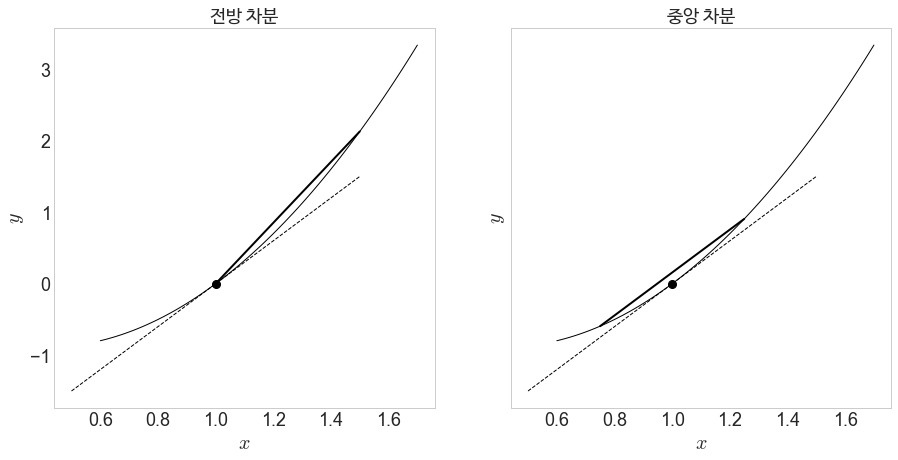

In [9]:
f  = lambda x : (x**2 + 2*x)*np.log(x)
df = lambda x : (2*x+2)*np.log(x) + (x+2)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches((15,7))

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_xlabel(r'$x$', fontsize=25)
ax1.set_ylabel(r'$y$', fontsize=25)
ax1.grid(False)

ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_xlabel(r'$x$', fontsize=25)
ax2.set_ylabel(r'$y$', fontsize=25)
ax2.grid(False)

x = np.linspace(0.6, 1.7, 100)
x0 = 1.0
h = 0.5

ax1.plot(x, f(x), color='k', lw=1)
ax1.set_title("전방 차분", fontproperties=fontprop)
ax1.plot(x0, f(x0), 'o', markersize=8, color='k', zorder=3)
ax1.plot([x0-h, x0+h], [f(x0)-df(x0)*h, f(x0)+df(x0)*h], '--', lw=1, color='k')
ax1.plot([x0, x0+h], [f(x0), f(x0+h)], lw=2, color='k')
ax1.set_xlabel(r'$x$', fontsize=20)
ax1.set_ylabel(r'$y$', fontsize=20)

ax2.plot(x, f(x), color='k', lw=1)
ax2.set_title("중앙 차분", fontproperties=fontprop)
ax2.plot(x0, f(x0), 'o', markersize=8, color='k', zorder=3)
ax2.plot([x0-h, x0+h], [f(x0)-df(x0)*h, f(x0)+df(x0)*h], '--', lw=1, color='k')
ax2.plot([x0-h/2, x0+h/2], [f(x0-h/2), f(x0+h/2)], lw=2, color='k')
ax2.set_xlabel(r'$x$', fontsize=20)
ax2.set_ylabel(r'$y$', fontsize=20)  

if file_print == True :
    fig.savefig("imgs/chap6/fig6-1.png", dpi=300, bbox_inches='tight')
    fig.savefig("imgs/chap6/fig6-1.pdf", format='pdf', bbox_inches='tight')

plt.show()

- 정확한 미분계수는 점선으로 표시된 직선의 기울기
- 전방차분과 중앙차분이 구하는 미분계수는 실선으로 표시된 직선의 기울기

#### 다변수 함수 편미분
- 위의 코드로 다변수 함수 편미분 가능 (식 6.5)




In [10]:
f_xy  = lambda x : (x[0]**2 + 2*x[0])*np.log(x[1])
numer_deriv(f_xy, np.array([1, 2]))

array([2.7726, 1.4989])

- 위 코드에서 x[0]와 x[1]은 식 (6.5)에서 x,y를 나타냄
- 반환된 값은 각 변수에 대한 미분계수

In [11]:
x = sympy.Symbol('x') 
y = sympy.Symbol('y') 
f_xy_sympy = (x**2 + 2*x)*sympy.log(y) 
df_xy_x = sympy.diff(f_xy_sympy, x) 
df_xy_y = sympy.diff(f_xy_sympy, y)

print(df_xy_x)
print(df_xy_y)

print("{:.4f}".format(df_xy_x.evalf(subs={x:1.0, y:2.0}))) # 심파이에서 얻은 식에 숫자를 대입하여 결과 계산하려면 evalf()함수 호출하면서 subs 사전형 인자를 사용해 변수대입값 지정
print("{:.4f}".format(df_xy_y.evalf(subs={x:1.0, y:2.0})))

(2*x + 2)*log(y)
(x**2 + 2*x)/y
2.7726
1.5000


- 수치미분한 결과와 거의 비슷한 결과
- 그러나 변수 개수만큼 루프를 돌면서 동일한 과정을 반복하므로 변수가 많아지면 속도가 현저히 느려짐

## 자동미분
- 연쇄법칙을 함수에 반복적으로 적용해 전체 함수에 대한 미분계수를 자동으로 계산
- 연쇄법칙을 적용할 가장 기본이 되는 단위함수에 대해 직접 미분으로 코드 구현 해야 함

### 파이토치로 자동미분하기

In [14]:
import torch # 파이토치 불러오기

#### 텐서
- 인공지능 분야에서는 다차원 배열 (= np.array)
- 파이토치에서 제공하는 자동미분 기능을 사용하기 위해서는 텐서 자료형에 데이터를 담아야 함

In [15]:
np.random.seed(0) # 랜덤 어레이 생성에서 늘 같은 결과가 나오게 하기 위해

x = np.random.rand(6).reshape(2,3)

# np.array를 tensor로 바꿀때 자주 사용하는 몇 가지 방법
x_tensor = torch.tensor(x)
x_from_numpy = torch.from_numpy(x)
x_Tensor = torch.Tensor(x)
x_as_tensor = torch.as_tensor(x)

# array와 tensor 출력, tensor는 숫자앞에 tensor표시
# torch.Tensor() 빼고는 모두 원래 데이터 타입 유지(float64)
print(x, x.dtype)
print(x_tensor, x_tensor.dtype, x_tensor.requires_grad)
print(x_from_numpy, x_from_numpy.dtype, x_from_numpy.requires_grad)
print(x_Tensor, x_Tensor.dtype, x_Tensor.requires_grad)
print(x_as_tensor, x_as_tensor.dtype, x_as_tensor.requires_grad)

[[0.5488 0.7152 0.6028]
 [0.5449 0.4237 0.6459]] float64
tensor([[0.5488, 0.7152, 0.6028],
        [0.5449, 0.4237, 0.6459]], dtype=torch.float64) torch.float64 False
tensor([[0.5488, 0.7152, 0.6028],
        [0.5449, 0.4237, 0.6459]], dtype=torch.float64) torch.float64 False
tensor([[0.5488, 0.7152, 0.6028],
        [0.5449, 0.4237, 0.6459]]) torch.float32 False
tensor([[0.5488, 0.7152, 0.6028],
        [0.5449, 0.4237, 0.6459]], dtype=torch.float64) torch.float64 False


- 이 책에서는 텐서 생성을 위해 torch.tensor() 또는 torch.Tensor() 사용
    - torch.Tensor()는 torch.FloatTensor()의 약칭이므로 데이터타입이 float32로 고정

In [16]:
x[0,0] = 100

print(x, x.dtype)
print(x_tensor, x_tensor.dtype, x_tensor.requires_grad)
print(x_from_numpy, x_from_numpy.dtype, x_from_numpy.requires_grad)
print(x_Tensor, x_Tensor.dtype, x_Tensor.requires_grad)
print(x_as_tensor, x_as_tensor.dtype, x_as_tensor.requires_grad)

[[100.       0.7152   0.6028]
 [  0.5449   0.4237   0.6459]] float64
tensor([[0.5488, 0.7152, 0.6028],
        [0.5449, 0.4237, 0.6459]], dtype=torch.float64) torch.float64 False
tensor([[100.0000,   0.7152,   0.6028],
        [  0.5449,   0.4237,   0.6459]], dtype=torch.float64) torch.float64 False
tensor([[0.5488, 0.7152, 0.6028],
        [0.5449, 0.4237, 0.6459]]) torch.float32 False
tensor([[100.0000,   0.7152,   0.6028],
        [  0.5449,   0.4237,   0.6459]], dtype=torch.float64) torch.float64 False


- np.array에서 데이터 요소를 하나 바꿨을 때 텐서에 일어나는 현상 확인
    - torch.from_numpy()와 torch.as_tensor()의 경우에만 값이 함께 바뀜
    - 위 두 방식만 어레이와 데이터를 공유, 나머지 방식은 데이터 복사하여 새롭게 텐서를 만든 것
    
- requires_grad
    - 독립변수로 입력받는 함수 텐서로 자동미분하기 위해서는 이 항목이 True로 설정되어 있어야 함
    - 다음처럼 텐서 생성

In [17]:
x_tensor_grad = torch.tensor(x, requires_grad=True)

print(x_tensor_grad, x_tensor_grad.dtype, x_tensor_grad.requires_grad)

tensor([[100.0000,   0.7152,   0.6028],
        [  0.5449,   0.4237,   0.6459]], dtype=torch.float64,
       requires_grad=True) torch.float64 True


#### torch.autograd.backward
- 파이토치에 있는 torch.autograd 모듈이 스칼라함수를 자동미분하는 기능제공
    - .backward()와 .grad()를 사용하는 두가지 방법이 있음
    
- 함수식 (6.1)을 .backward()를 통해 미분
    - f(x) = (x^2 + 2x)lnx
    - 위 함수는 곱셈, 덧셈, 로그함수를 통해 계산되는 연산덩어리라고 할 수 있음
    - backward()함수는 계산그래프의 끝에서 거꾸로 계산 그래프의 시작까지 거슬러 올라가며 사용자 변수에 대한 미분계수 구해줌

In [18]:
x = torch.tensor([1.0], requires_grad=True) # 값이 1.0인 텐서형 변수 x 선언
f = (x**2 + 2*x) * torch.log(x) # 식(6.1) 정의

print(x)
print(f)
print(x.grad)

print(x.grad_fn)
print(f.grad_fn)

tensor([1.], requires_grad=True)
tensor([0.], grad_fn=<MulBackward0>)
None
None


In [19]:
# x가 마지막 노드인가? 
# backward()함수는 마지막 노드까지 역전파하면서 미분계수를 구한다.
print(x.is_leaf)

True


- x는 requires_grad = True로, 미분할 수 있는 변수임 (f를 x로 미분가능)
- f는 계산된 값 0 출력, grad_fn 값 설정
    - grad_fn이 MulBackward0로 설정된 것은 이 변수 값이 곱셈을 통해 계산되었으며, 곱셈미분법을 이용하여 미분계수 구할 수 있음
- x.grad는 미분계수를 나타냄.
    - None : 아직 계산되지 않았음

In [20]:
torch.autograd.backward(f, grad_tensors=torch.tensor([1.]), retain_graph=True)
print(x.grad)

tensor([3.])


- backward()를 통해 미분을 할 때, 미분해야 하는 함수 f를 넘겨줌
    - 함수가 실행되면 f값을 위해 계산에 참여한 변수에 대한 미분계수 구함
    - 이 과정은 계산 그래프를 통해 수행되므로, 메모리에 미분을 위한 계산 그래프 구성
    - 기본적으로 한 번 미분계수를 구하고 나서 계산그래프 삭제
    - 미분반복을 위해 계산그래프를 유지하려고 할 때 retain_graph = True 지정

- x.grad 값은 3이 출력됨

#### torch.autograd.grad
- grad() 함수가 배워온 미분과정과 더 잘 부합
    - 종속변수와 미분할 변수 모두 명시적으로 지정해주고, 반환값으로 바로 미분계수 돌려받기 때문

In [21]:
df = torch.autograd.grad(f, x, retain_graph=True)
print(df)

(tensor([3.]),)


- torch.autograd.grad()에 f와 미분할 변수 x를 넘겨줌
- backward()와는 다르게 반환값이 튜플로 묶여져 있음
    - grad()함수에 미분하고자 하는 변수를 여러 개 지정할 수 있기 때문

In [22]:
df = torch.autograd.grad(f,  (x, x), retain_graph=True)
print(df)

(tensor([3.]), tensor([3.]))


- 식 (6.5)와 같이 이변수 함수라면 다음 코드처럼 미분

In [23]:
x = torch.tensor([1.0], requires_grad=True)
y = torch.tensor([2.0], requires_grad=True)
f_xy = (x**2 + 2*x) * torch.log(y)

torch.autograd.backward(f_xy, retain_graph=True)
print(x.grad)
print(y.grad)

df = torch.autograd.grad(f_xy, (x,y), retain_graph=True)
print(df)

tensor([2.7726])
tensor([1.5000])
(tensor([2.7726]), tensor([1.5000]))


- backward()를 수행한 경우 참여변수 x,y에 대한 미분계수를 x.grad, y.grad에 자동저장
- grad()는 호출 시 미분하고자 하는 변수를 명시적으로 지정, 반환값도 미분계수의 튜플로 반환
- 결과는 sympy로 구한 미분계수와 일치

### 자동미분 간단예제
- 자동미분을 구현하는 방법은 포워드 모드와 리버스 모드 두 가지 방식
    - 두 방식 모두 미분하고자 하는 함수를 계산 그래프로 만들어 미분계수를 계산하는데 이용
    - 계산그래프 기준 왼쪽에서 오른쪽으로 진행시키는 경로를 포워드 패스라고 함 (= 순전파, forward propagation)
    - 반대로 오른쪽에서 왼쪽으로 진행하는 경로를 백워드 패스라고 함 (= 역전파, back propagation)

- 책에서는 역전파만 다룸

#### 연쇄법칙 복습
- 연쇄법칙은 합성된 각 함수에 대한 도함수를 서로 곱하는 것
- '자기 자신에 대한 입력으로 미분한 결과를 서로 곱한다'

#### 연쇄법칙의 다변수 함수 확장
- z = x * y의 예시 (책 p.154 ~ 155)

#### 자동미분 구현
- 전체 함수를 구성하고 있는 작은 단위 함수에 대한 미분계수를 알면 그것을 반복적으로 곱하면서 전체함수의 미분계수 구할 수 있음
- 식(6.5) 미분 코드
    - 기본적인 단위 함수의 함숫값과 도함숫값을 구하는 코드 필요
    - 식 (6.5)에는 곱셈, 덧셈, 로그연산이 있으므로 각 경우에 대해 편도함수를 구할 수 있어야 함

In [24]:
# 곱셈 구현

# 두 값을 넘겨받아 곱을 반환하는 함수
def times(x, y):
    return x*y, (x,y) # 미분하는데 필요한 정보 함숫값과 함께 넘겨줌

def times_deriv(cache, dout=1):
    return cache[1]*dout, cache[0]*dout # 도함수의 정의, cache와 상류층 미분계수 dout을 넘겨받아 미분계수 계산
                                         # 입력의 위치를 바꾸고 상류층 미분계수 dout을 곱해서 반환 (기본값 = 1)

TIMES = {'f': times, 'df': times_deriv} # TIMES라는 dictionary에 곱셈함수를 키 값 f로 저장

v, cache = TIMES['f'](2,3) # 방금 만든 함수 호출하여 함숫갑소가 미분계수 계산하기위한 정보를 v, cache라는 변수에 저장
dx, dy = TIMES['df'](cache) # TIMES['df']에 저장된 함수 호출하여 미분계수 계산

print("dx={}, dy={}".format(dx, dy))

dx=3, dy=2


In [25]:
# 덧셈 및 로그도 위와 비슷하게 구현

def add(x, y):
    return x+y, (x,y)

def add_deriv(cache, dout=1):
    return dout, dout

ADD = {'f': add, 'df': add_deriv}

def log(x):
    return np.log(x), x

def log_deriv(cache, dout=1):
    return (1/cache)*dout

LOG = {'f': log, 'df': log_deriv}

- 덧셈 함수는 각 변수에 대해 편미분하면 미분계수가 항상 1임
    - 항상 상류층 미분계수를 그냥 반환하면 됨
    - cache인자가 필요없지만, 인터페이스 통일을 위해 적음

- 로그함수는 로그미분 공식 ln(x))' = 1/x 그대로 사용

In [26]:
# 식 (6.5) 미분

x = 1.; y = 2.

# 단위함수 순전파, 각 단계마다 함숫값과 추가 정보를 적절한 변수에 저장
a, cache_a = TIMES['f'](x, x)
b, cache_b = TIMES['f'](2, x)
c, cache_c = ADD['f'](a, b)
d, cache_d = LOG['f'](y)
z, cache_z = TIMES['f'](c, d)

print("forward pass f(x) = {:.6f}".format(z))


dx = dy = 0. # 미분계수 저장할 변수 초기화
dc, dd = TIMES['df'](cache_z, 1) # 마지막 곱셈함수 호출하면서 미분계수 계산, 마지막 곱셈함수 입력 c,d 였으므로 미분계수는 두 개
dy = LOG['df'](cache_d, dd) # cache_d와 dd를 이용하여 로그함수에 대한 미분계수 구함
da, db = ADD['df'](cache_c, dc)
_, dx_ = TIMES['df'](cache_b, db); dx+=dx_; # 곱셈도 같은 방식으로 미분, 상수 2에 대한 미분계수에는 관심 없으므로 _라는 변수에 저장
dx_, dx__ = TIMES['df'](cache_a, da); dx+=dx_+dx__;


print("backward pass dx = {:.6f}, dy = {:.6f}".format(dx, dy))


forward pass f(x) = 2.079442
backward pass dx = 2.772589, dy = 1.500000


- 파이토치로 상류층 미분계수를 2로 주고 미분한 경우

In [27]:
x = torch.tensor([1.], requires_grad=True)
y = torch.tensor([2.], requires_grad=True)

z = (x**2 + 2*x)*torch.log(y)

dz = torch.autograd.grad(z, (x,y), grad_outputs=torch.tensor([2.]), retain_graph=True)
print(dz)

(tensor([5.5452]), tensor([3.]))
